In [28]:
import torch
import json
import librosa
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from  multiprocessing import Pool

import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import IntProgress
IntProgress(10,max=100)

import warnings
warnings.filterwarnings("ignore")

In [3]:
model = torch.hub.load('harritaylor/torchvggish', 'vggish', 
                       pretrained=True, preprocess=True, postprocess=False)
model.eval()

Using cache found in /home/gerardo/.cache/torch/hub/harritaylor_torchvggish_master


VGGish(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [35]:
path = Path('/media/gerardo/TOSHIBA/DataSets/DAMP/DAMP-VSEP')
data_path = '/home/gerardo/Projects/DAMP-VSEP-Singles/metadata/valid_dataset.json'

In [36]:
data = json.load(open(data_path, 'r'))

In [37]:
features = []

In [38]:
input = []
for key in data.keys():
    input.append(path/data[key]['background'])

In [39]:
def func(path):
    audio, _ = librosa.load(path, sr=16000)
    emb = model.forward(audio, fs=16000)
    emb = torch.mean(emb, dim=0)
    return emb.data.numpy()

pool = Pool(processes=1)
for emb in tqdm(pool.imap_unordered(func, input), total=len(input)):
    features.append(emb)

Process ForkPoolWorker-49:
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/media/gerardo/Extended/conda_envs/sseparation/lib/python3.8/multiprocessing/connection.py", line 3

In [40]:
print(np.array(features).shape)

(1125, 128)


In [41]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [42]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000).fit_transform(features)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1125 samples in 0.010s...
[t-SNE] Computed neighbors for 1125 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1125
[t-SNE] Computed conditional probabilities for sample 1125 / 1125
[t-SNE] Mean sigma: 0.571648
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.185192
[t-SNE] KL divergence after 2000 iterations: 0.077967


In [43]:
scaler = MinMaxScaler()
scaler.fit(X_embedded)
tsne_features = scaler.transform(X_embedded)

In [44]:
df_tsne = pd.DataFrame(tsne_features, columns=['tsne2d-one', 'tsne-2d-two'])

<AxesSubplot:xlabel='tsne2d-one', ylabel='tsne-2d-two'>

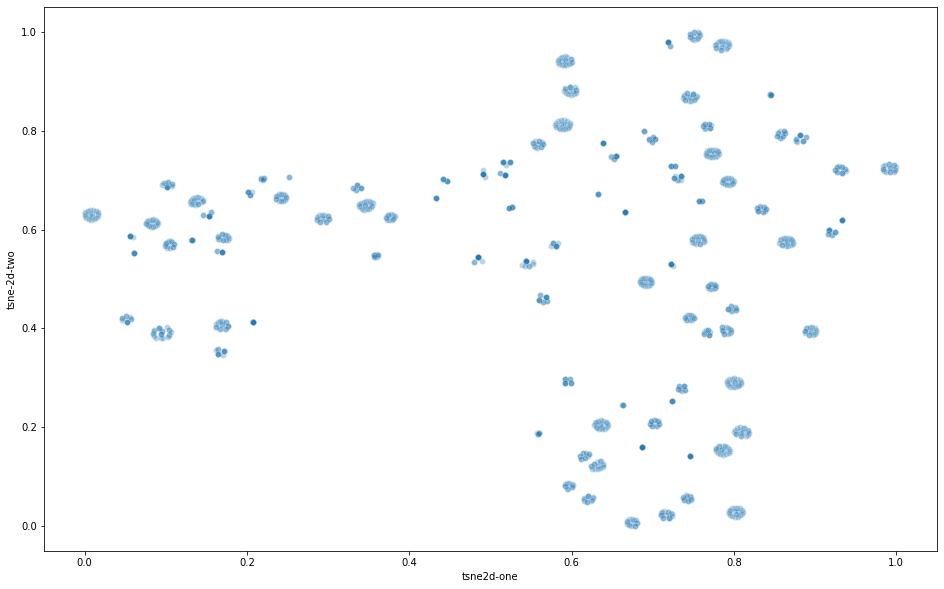

In [45]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne2d-one", y="tsne-2d-two",
    #hue="label",
    #palette=sns.color_palette("hls", 11),
    data=df_tsne,
    legend="full",
    alpha=0.3
)